## Contents

#### 1. Finite Difference Gradient
#### 2. Analytics Gradient
#### 3. Quantum Natural Gradient
#### 4. Quantum Natural Gradient Versus Analytic Gradient 

In [10]:
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_algorithms.gradients import LinCombEstimatorGradient
from qiskit_algorithms.optimizers import GradientDescent
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Pauli
from matplotlib import pyplot as plt
import numpy as np

#### Ansatz

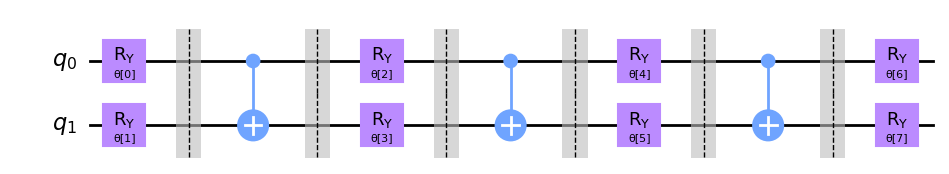

In [36]:
ansatz = RealAmplitudes(num_qubits = 2, entanglement = 'linear', insert_barriers = True).decompose()
EPS = 0.2   # Epsilon value
param_values = np.random.rand(ansatz.num_parameters)   # randomly generating parameters' values
ansatz.draw('mpl')

#### Hamiltonian

In [12]:
Z = Pauli('Z')   # Pauli Z operator
hamiltonian = Z ^ Z

In [25]:
## Estimator

estimator = Estimator()

## Finite difference gradient

Circuit parameters: [ 0.36698569 -0.10417474 -0.22031969  0.59005443  0.03222243 -0.58416233
  0.06481168  0.88872475]


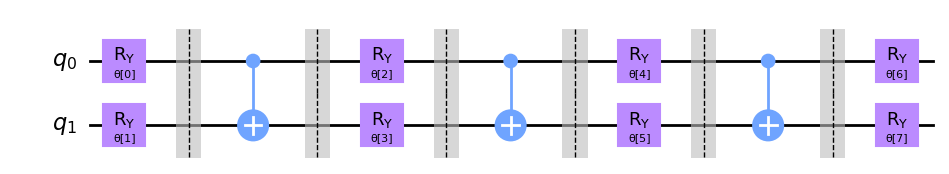

In [26]:
gradient = FiniteDiffEstimatorGradient(estimator, EPS)

gradients = gradient.run(ansatz, hamiltonian, [param_values]).result().gradients[0]

print(f'Circuit parameters:', gradients)

ansatz.draw(output = 'mpl')

## Objective function or Expectation Value

In [27]:
def expectation(ansatz, hamiltonian, estimator):
    def eval_expectation(param_values):
        bound_ansatz = ansatz.bind_parameters(dict(zip(ansatz.parameters, param_values)))
        expectation_value = estimator.run(bound_ansatz, hamiltonian).result().values[0]
        return expectation_value
    return eval_expectation

# Analytic Gradient Descent

* it basically uses parameter shift rules

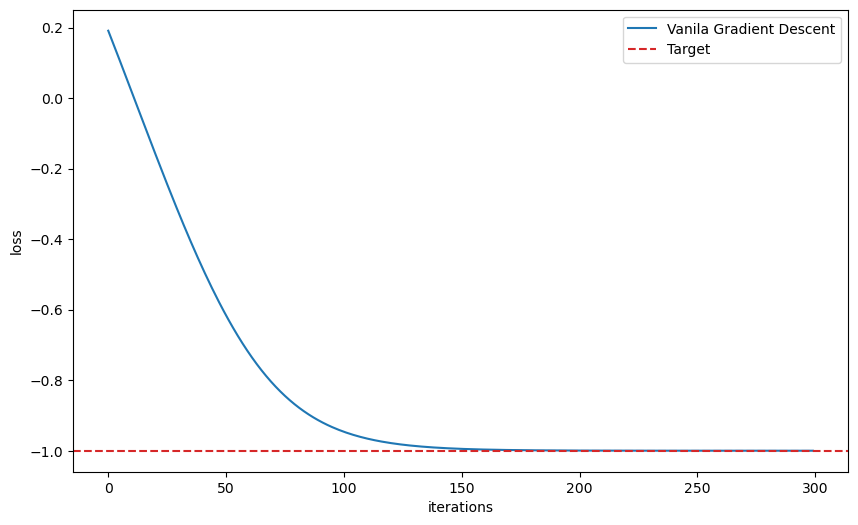

In [31]:
def gradient(estimator, ansatz, hamiltonian):
    def eval_gradient(param_values):
        gradient = ParamShiftEstimatorGradient(estimator)
        gradients = gradient.run(ansatz, hamiltonian, parameter_values = [param_values]).result().gradients[0]
        return gradients
    return eval_gradient


class OptimizerLog:
    'Log to store intermediate results of Optimizer'
    def __init__(self):
        self.loss = []
    
    def update(self,  _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

gd_log = OptimizerLog()
gd = GradientDescent(maxiter = 300, 
                     learning_rate = 0.01, 
                     callback = gd_log.update)

result = gd.minimize(fun = expectation(ansatz, hamiltonian, estimator), #function to minimize
                     x0 = param_values,   #Initial Points
                     jac = gradient(estimator, ansatz, hamiltonian)
                    )

'Ploting the curves'
plt.figure(figsize = (10, 6))
plt.plot( gd_log.loss, label = 'Vanila Gradient Descent')
plt.axhline(-1, ls = '--', c = 'C3', label = 'Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

# ansatz.draw(output = 'mpl')

# Quantum natural Gradient

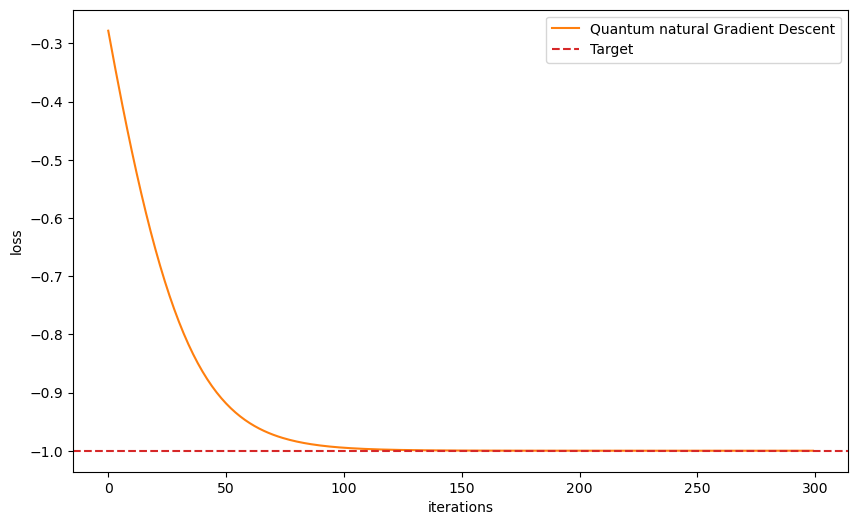

In [33]:
estimator = Estimator()

def expectation(ansatz, estimator, hamiltonian):
    def eval_expectation(param_values):
        ansatz_bound = ansatz.bind_parameters(dict(zip(ansatz.parameters, param_values)))
        expectation_value = estimator.run(ansatz_bound, hamiltonian).result().values[0]
        return expectation_value
    
    return eval_expectation

def eval_gradient(ansatz, estimator, hamiltonian):
    def gradient(param_values):
        gradient = LinCombEstimatorGradient(estimator)
        gradients = gradient.run(ansatz, hamiltonian, parameter_values = [param_values]).result().gradients[0]
        return gradients

    return gradient
        
class OptimizerLog1:
    'Log to store intermediate results of Optimizer'
    def __init__(self):
        self.loss = []
    
    def update(self,  _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

qgd_log = OptimizerLog1()
from qiskit_algorithms.optimizers import GradientDescent
qgd = GradientDescent(maxiter = 300, learning_rate = 0.01, callback = qgd_log.update)

result = qgd.minimize(fun = expectation(ansatz, estimator, hamiltonian),
                      x0 = param_values,
                      jac = eval_gradient(ansatz, estimator, hamiltonian))

'Ploting the curves'
plt.figure(figsize = (10, 6))
plt.plot(qgd_log.loss, 'C1', label = 'Quantum natural Gradient Descent')
plt.axhline(-1, ls = '--', c = 'C3', label = 'Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

# ansatz.draw(output = 'mpl')

## Quantum natural Gradient Versus Analytics gradient

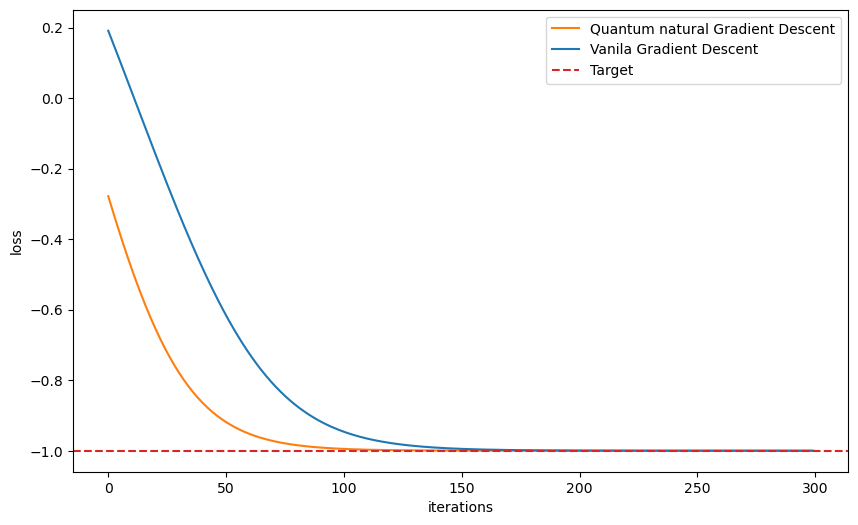

In [34]:
'Ploting the curves'
plt.figure(figsize = (10, 6))
plt.plot(qgd_log.loss, 'C1', label = 'Quantum natural Gradient Descent')
plt.plot(gd_log.loss, label = 'Vanila Gradient Descent')
plt.axhline(-1, ls = '--', c = 'C3', label = 'Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()